In [1]:
import mne
import openneuro
from mne_bids import BIDSPath, read_raw_bids
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.cluster import ModKMeans

# Параметры датасета
dataset = "ds005385"
subject = "001"
bids_root = Path("./data") / dataset # ./data/ds005385

# Проверяем, существует ли уже папка с данными субъекта
subject_path = bids_root / f"sub-{subject}"
if subject_path.exists():
    print("Данные уже скачаны. Пропускаем этап загрузки.")
else:
    # Создаем папку ./data/ds005385 если она не существует.
    # parents=True гарантирует создание промежуточных папок в пути
    # exist_ok=True не вернёт ошибку, если папка уже существует
    bids_root.mkdir(parents=True, exist_ok=True)
    print("Скачиваем данные...")
    # Скачиваем данные одного субъекта
    openneuro.download(
        dataset=dataset,
        target_dir=bids_root, # Задаём путь для сохранения
        include=[f"sub-{subject}"] # Фильтрует загрузку, скачиваем только связанные с sub-001 файлы
    )

Данные уже скачаны. Пропускаем этап загрузки.


In [2]:
print("Изучаем структуру BIDS датасета...")
# Просмотр структуры скачанных файлов
def explore_bids_structure(bids_root):
    print("Структура датасета:")
    for path in bids_root.rglob("*"): # Рекурсивно (по всем уровням папок) обходит все файлы в директории BIDS
        if path.is_file(): # Игнорирует переходы между файлами. Т.е. возвращает True, если path ведёт к файлу.
            relative_path = path.relative_to(bids_root) # Обрезает путь до начала после sub-001
            print(f"  {relative_path}")

explore_bids_structure(bids_root)

# Загрузка данных через MNE-BIDS.
# BIDSPath - специальный объект библиотеки MNE-BIDS,
# который автоматически строит правильные пути к файлам согласно стандарту BIDS.
bids_path = BIDSPath(
    subject=subject,      # '001'
    session='1',          # ses-001 - следующая папка после sub-001
    task='EyesOpen',    # Условие: открытые глаза
    acquisition='post',   # После вмешательства
    datatype='eeg',
    root=bids_root
)

# Загружаем данные
raw = read_raw_bids(bids_path) # Специальная функция, загружает EEG данные и всю сопутствующую информацию в объект MNE "raw"
print("Данные успешно загружены!")
print(raw)

Изучаем структуру BIDS датасета...
Структура датасета:
  CHANGES
  dataset_description.json
  participants.json
  participants.tsv
  sub-001\sub-001_sessions.json
  sub-001\sub-001_sessions.tsv
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-post_channels.tsv
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-post_eeg.edf
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-post_eeg.json
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-post_events.json
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-post_events.tsv
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-pre_channels.tsv
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-pre_eeg.edf
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-pre_eeg.json
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-pre_events.json
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesClosed_acq-pre_events.tsv
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesOpen_acq-post_channels.tsv
  sub-001\ses-2\eeg\sub-001_ses-2_task-EyesOp

C:\Users\me\AppData\Local\Temp\ipykernel_37212\1119143803.py:25: RuntimeWarning: The number of channels in the channels.tsv sidecar file (64) does not match the number of channels in the raw data file (65). Will not try to set channel names.
  raw = read_raw_bids(bids_path) # Специальная функция, загружает EEG данные и всю сопутствующую информацию в объект MNE "raw"
C:\Users\me\AppData\Local\Temp\ipykernel_37212\1119143803.py:25: RuntimeWarning: Unable to map the following column(s) to to MNE:
handedness: right
session1: yes
late_ses1: 0
session2: yes
late_ses2: 0
  raw = read_raw_bids(bids_path) # Специальная функция, загружает EEG данные и всю сопутствующую информацию в объект MNE "raw"


=== ИНФОРМАЦИЯ О ДАННЫХ ===
Количество EEG-каналов в записи: 65
Частота дискретизации: 1000.0 Гц
Длительность записи: 185.00 секунд
Типы каналов: {2 (FIFFV_EEG_CH), 3 (FIFFV_STIM_CH)}
Устанавливаем стандартное расположение электродов 10-20...
Загружаем данные в оперативную память...
Reading 0 ... 184999  =      0.000 ...   184.999 secs...
Применяем средний референт...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Применяем полосовой фильтр 1-40 Гц...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.

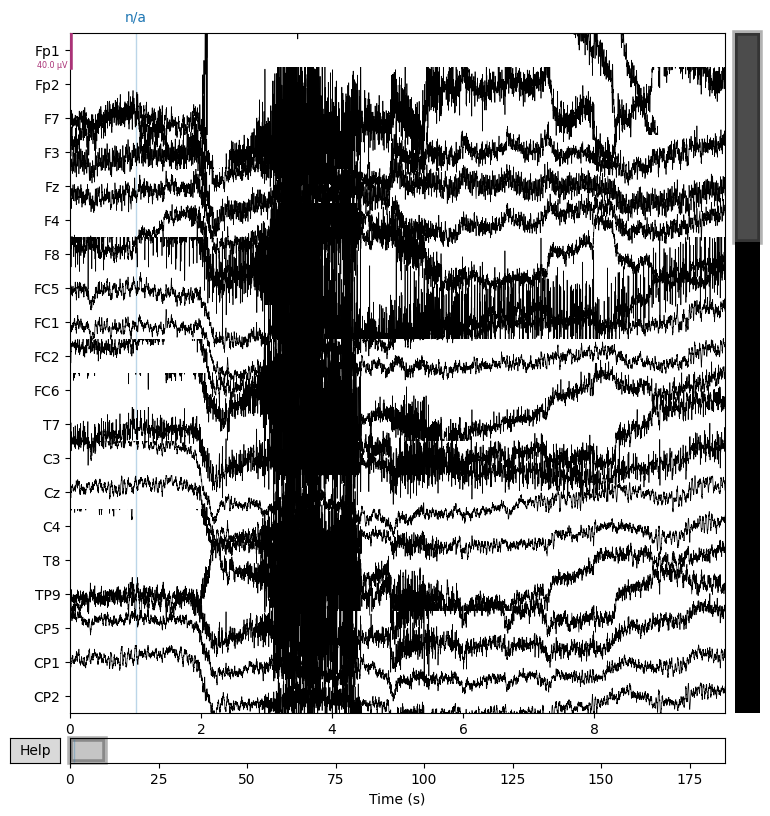

Визуализация отфильтрованных данных...


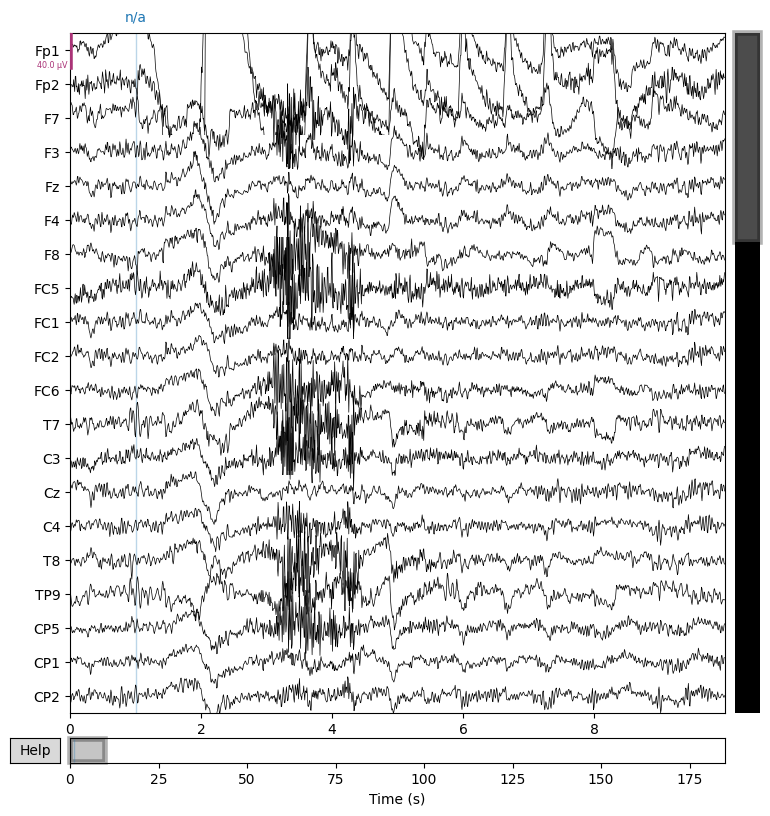

=== ОЧИСТКА ДАННЫХ С ПОМОЩЬЮ ICA ===
Выполняем ICA...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 11.2s.
Автоматическое определение артефактных компонент...


C:\Users\me\AppData\Local\Temp\ipykernel_37212\364694932.py:42: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_ica, ica, method="iclabel")
C:\Users\me\AppData\Local\Temp\ipykernel_37212\364694932.py:42: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw_ica, ica, method="iclabel")



Результаты классификации компонент:
Компонента 0: other (вероятность: 0.791)
Компонента 1: eye blink (вероятность: 0.945)
Компонента 2: eye blink (вероятность: 0.473)
Компонента 3: eye blink (вероятность: 0.998)
Компонента 4: brain (вероятность: 0.995)
Компонента 5: brain (вероятность: 0.999)
Компонента 6: brain (вероятность: 0.966)
Компонента 7: brain (вероятность: 0.994)
Компонента 8: brain (вероятность: 0.993)
Компонента 9: brain (вероятность: 0.740)
Компонента 10: muscle artifact (вероятность: 0.850)
Компонента 11: muscle artifact (вероятность: 0.724)
Компонента 12: other (вероятность: 0.572)
Компонента 13: other (вероятность: 0.751)
Компонента 14: muscle artifact (вероятность: 0.980)
Исключаем компоненту 1 как eye blink (вероятность: 0.945)
Исключаем компоненту 3 как eye blink (вероятность: 0.998)
Исключаем компоненту 10 как muscle artifact (вероятность: 0.850)
Исключаем компоненту 14 как muscle artifact (вероятность: 0.980)

Визуализация компонент ICA...


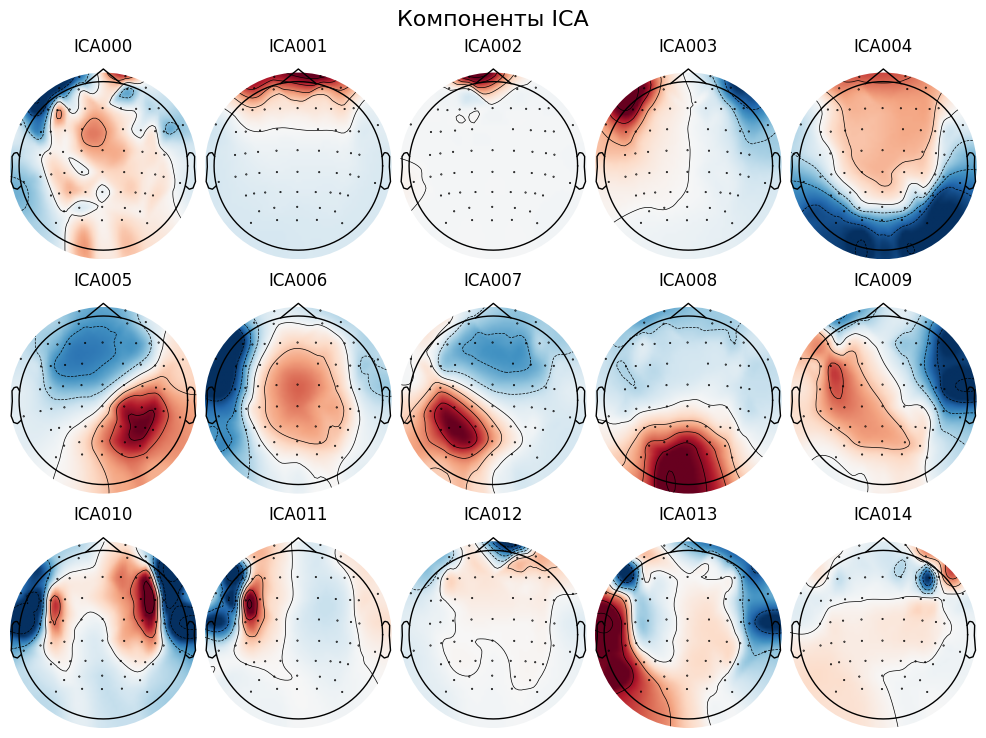

Удаляем 4 артефактных компонент...
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components
Очистка ICA завершена!


In [3]:
# Информация о данных
print("=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Количество EEG-каналов в записи: {len(raw.ch_names)}")
print(f"Частота дискретизации: {raw.info['sfreq']} Гц")  # Сколько раз в секунду записывался сигнал, 'sfreq' измерений/секунду
print(f"Длительность записи: {raw.times[-1]:.2f} секунд") # raw.times - массив временных меток, [-1] берёт последний элемент = общая длительность
print(f"Типы каналов: {set(ch['kind'] for ch in raw.info['chs'])}") # Создает множество уникальных типов каналов для вывода

# Установка расположения электродов (если отсутствует)
if raw.info['dig'] is None: # Проверяет наличие цифровых координат электродов
    print("Устанавливаем стандартное расположение электродов 10-20...")
    raw.set_montage('standard_1020') # Устанавливает стандартную систему 10-20

print("Загружаем данные в оперативную память...")
raw.load_data()

# Возможно поможет
print("Применяем средний референт...")
raw.set_eeg_reference('average')

# Фильтрация данных (стандартный диапазон ЭЭГ)
print("Применяем полосовой фильтр 1-40 Гц...")
raw_filtered = raw.copy().filter(1, 40)

print("Визуализация сырых данных...")
raw.plot(title="Сырые данные", block=True)

print("Визуализация отфильтрованных данных...")
raw_filtered.plot(title="Отфильтрованные данные (1-40 Гц)", block=True)

print("=== ОЧИСТКА ДАННЫХ С ПОМОЩЬЮ ICA ===")

# Создаем копию данных для ICA
raw_ica = raw_filtered.copy()

# 1. Выполняем ICA
print("Выполняем ICA...")
ica = ICA(n_components=15, max_iter='auto', random_state=42, method='picard')
ica.fit(raw_ica)

# 2. Автоматическое определение артефактных компонент
print("Автоматическое определение артефактных компонент...")
ic_labels = label_components(raw_ica, ica, method="iclabel")
labels = ic_labels["labels"]
scores = ic_labels["y_pred_proba"]

# Выводим информацию о компонентах
print("\nРезультаты классификации компонент:")
for i, (label, score) in enumerate(zip(labels, scores)):
    print(f"Компонента {i}: {label} (вероятность: {score:.3f})")

# 3. Автоматически исключаем компоненты с высокой вероятностью артефактов
artifact_components = []
for i, (label, score) in enumerate(zip(labels, scores)):
    if label in ['eye blink', 'muscle artifact', 'heart beat', 'line noise', 'channel noise'] and score > 0.8:
        artifact_components.append(i)
        print(f"Исключаем компоненту {i} как {label} (вероятность: {score:.3f})")

# 4. Визуализация компонент для ручной проверки
print("\nВизуализация компонент ICA...")
ica.plot_components(inst=raw_ica, show=False)
plt.suptitle("Компоненты ICA", fontsize=16)
plt.show()

# 5. Применяем ICA для удаления артефактных компонент
if artifact_components:
    print(f"Удаляем {len(artifact_components)} артефактных компонент...")
    ica.exclude = artifact_components
    raw_cleaned = ica.apply(raw_ica.copy())
else:
    print("Артефактные компоненты не обнаружены, используем исходные данные")
    raw_cleaned = raw_ica.copy()

print("Очистка ICA завершена!")

Обнаружение артефактов...
=== АНАЛИЗ ДО ОЧИСТКИ ICA ===
Найдено 9211 samples с артефактами
Процент артефактов: 4.98%
Effective window size : 2.048 (s)
=== АНАЛИЗ ПОСЛЕ ОЧИСТКИ ICA ===
Найдено 3299 samples с артефактами
Процент артефактов: 1.78%
Effective window size : 2.048 (s)
Артефакты до ICA: 9211 samples
Артефакты после ICA: 3299 samples
Plotting power spectral density (dB=True).


C:\Users\me\AppData\Local\Programs\Python\Python314\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


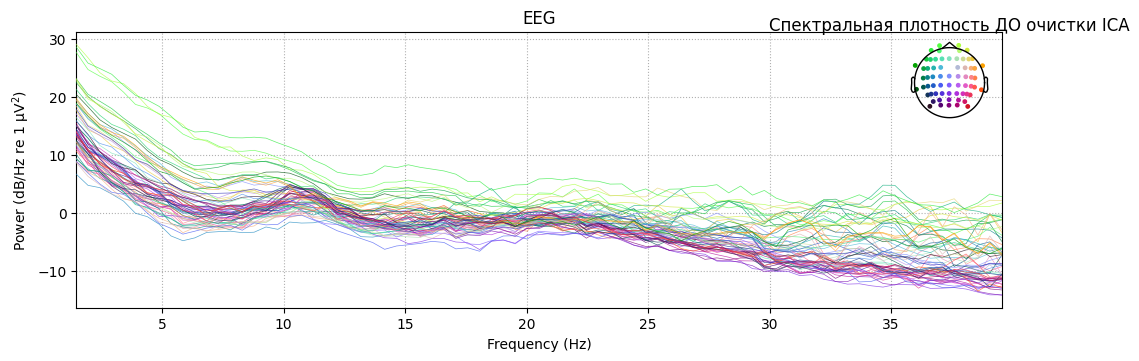

Plotting power spectral density (dB=True).


C:\Users\me\AppData\Local\Programs\Python\Python314\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


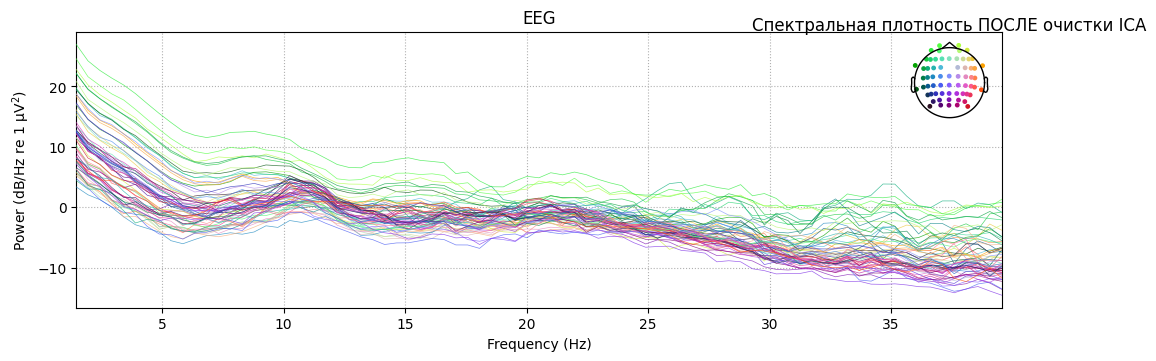

Строим топографические карты для очищенных данных...
converting legacy list-of-tuples input to a dict for the `bands` parameter
converting legacy list-of-tuples input to a dict for the `bands` parameter
converting legacy list-of-tuples input to a dict for the `bands` parameter
converting legacy list-of-tuples input to a dict for the `bands` parameter


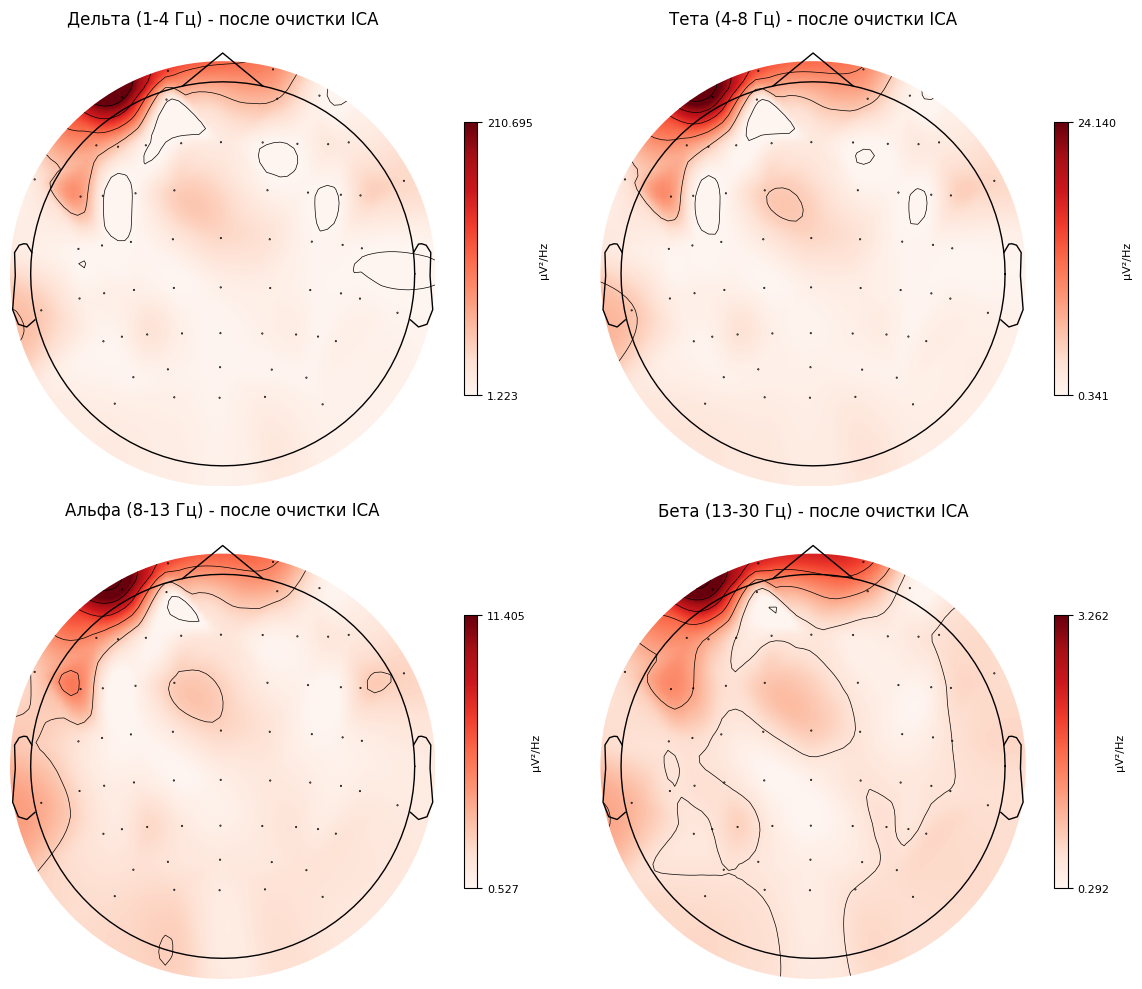

In [4]:
# Обнаружение и маркировка артефактов
print("Обнаружение артефактов...")
def detect_artifacts_simple(raw_data, threshold=100e-6): # threshold=100e-6 = 100 микроВольт - типичный порог для EEG
    """
    Простой метод обнаружения артефактов по амплитуде
    threshold: порог амплитуды в Вольтах (100 мкВ по умолчанию)
    """
    data = raw_data.get_data() # Преобразует в numpy array [каналы × время]
    # Находит все точки где амплитуда превышает порог, отмечает момент времени как артефакт если ЛЮБОЙ канал превысил порог
    artifact_mask = np.any(np.abs(data) > threshold, axis=0)
    artifact_times = raw_data.times[artifact_mask] # Временные метки артефактов
    
    print(f"Найдено {np.sum(artifact_mask)} samples с артефактами")
    print(f"Процент артефактов: {np.mean(artifact_mask)*100:.2f}%")
    
    return artifact_mask, artifact_times

print("=== АНАЛИЗ ДО ОЧИСТКИ ICA ===")
artifact_mask_before, artifact_times_before = detect_artifacts_simple(raw_filtered)
psd_before = raw_filtered.compute_psd(fmin=1, fmax=40)

print("=== АНАЛИЗ ПОСЛЕ ОЧИСТКИ ICA ===")  
artifact_mask_after, artifact_times_after = detect_artifacts_simple(raw_cleaned)
psd_after = raw_cleaned.compute_psd(fmin=1, fmax=40)

# Сравнение
print(f"Артефакты до ICA: {np.sum(artifact_mask_before)} samples")
print(f"Артефакты после ICA: {np.sum(artifact_mask_after)} samples")

# Визуализация спектров до и после
psd_before.plot(average=False, spatial_colors=True)
plt.title('Спектральная плотность ДО очистки ICA')
plt.show()

psd_after.plot(average=False, spatial_colors=True) 
plt.title('Спектральная плотность ПОСЛЕ очистки ICA')
plt.show()

print("Строим топографические карты для очищенных данных...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
bands = [
    (1, 4, 'Дельта'), 
    (4, 8, 'Тета'), 
    (8, 13, 'Альфа'), 
    (13, 30, 'Бета')
]

for idx, (fmin, fmax, band_name) in enumerate(bands):
    ax = axes[idx // 2, idx % 2]
    try:
        # Используем psd_after вместо psd
        psd_after.plot_topomap(bands=[(fmin, fmax, band_name)], axes=ax, show=False)
        ax.set_title(f'{band_name} ({fmin}-{fmax} Гц) - после очистки ICA')
    except Exception as e:
        print(f"Ошибка при построении {band_name}: {e}")

plt.tight_layout()
plt.show()


=== АНАЛИЗ 10 МИКРОСОСТОЯНИЙ ===
Извлекаем пики GFP...

=== Анализ 10 микросостояний ===
Кластеризация...
Визуализация топографий микросостояний...


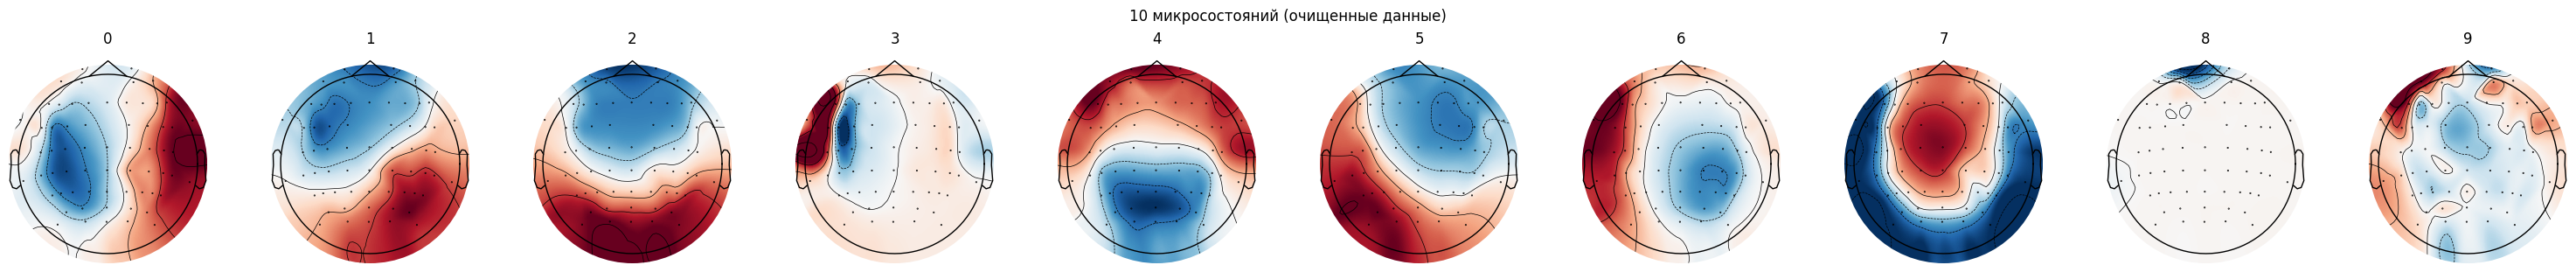

Сегментация данных...
Визуализация сегментации...


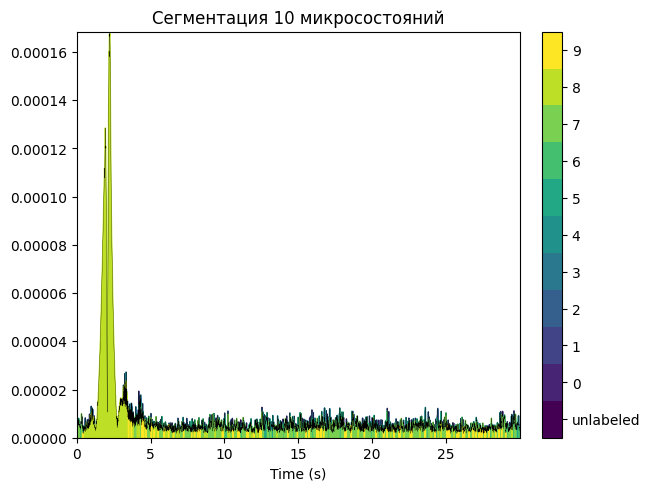


Статистика для 10 микросостояний:
  - Общая длительность анализа: 185.0 сек
  - Частота дискретизации: 1000.0 Гц
  - Всего samples: 185000
  - Распределение по состояниям:
    Состояние -1: 0.0 сек (0.0%)
    Состояние 0: 20.5 сек (11.1%)
    Состояние 1: 23.3 сек (12.6%)
    Состояние 2: 25.3 сек (13.7%)
    Состояние 3: 5.1 сек (2.7%)
    Состояние 4: 26.3 сек (14.2%)
    Состояние 5: 25.6 сек (13.9%)
    Состояние 6: 24.5 сек (13.3%)
    Состояние 7: 25.1 сек (13.6%)
    Состояние 8: 3.9 сек (2.1%)
    Состояние 9: 5.3 сек (2.9%)
  - Количество переходов между состояниями: 20319
  - Средняя длительность состояния: 0.01 сек

Анализ 10 микросостояний завершен!


In [5]:
# === АНАЛИЗ 10 МИКРОСОСТОЯНИЙ НА ОЧИЩЕННЫХ ДАННЫХ ===
print("\n=== АНАЛИЗ 10 МИКРОСОСТОЯНИЙ ===")

# 1. Используем ОЧИЩЕННЫЕ данные
eeg_picks_cleaned = mne.pick_types(raw_cleaned.info, eeg=True)
raw_eeg_cleaned = raw_cleaned.copy().pick(eeg_picks_cleaned)

# 2. Извлекаем пики GFP из очищенных данных
print("Извлекаем пики GFP...")
gfp_peaks_cleaned = extract_gfp_peaks(raw_eeg_cleaned)

# 3. Анализируем 10 микросостояний
n_clusters = 10

print(f"\n=== Анализ {n_clusters} микросостояний ===")

# Кластеризация
print("Кластеризация...")
kmeans = ModKMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(gfp_peaks_cleaned)

# Визуализация
print("Визуализация топографий микросостояний...")
fig = kmeans.plot()
plt.suptitle(f'{n_clusters} микросостояний (очищенные данные)')
plt.show()

# Сегментация
print("Сегментация данных...")
microstates = kmeans.predict(raw_eeg_cleaned)

print("Визуализация сегментации...")
microstates.plot(0, 30)
plt.title(f'Сегментация {n_clusters} микросостояний')
plt.show()

# Статистика
print(f"\nСтатистика для {n_clusters} микросостояний:")

# Основная статистика из сегментации
segmentation = microstates
unique, counts = np.unique(segmentation.labels, return_counts=True)
total_samples = len(segmentation.labels)
total_duration = total_samples / raw_eeg_cleaned.info['sfreq']

print(f"  - Общая длительность анализа: {total_duration:.1f} сек")
print(f"  - Частота дискретизации: {raw_eeg_cleaned.info['sfreq']} Гц")
print(f"  - Всего samples: {total_samples}")

print(f"  - Распределение по состояниям:")
for state, count in zip(unique, counts):
    percentage = (count / total_samples) * 100
    duration_seconds = count / raw_eeg_cleaned.info['sfreq']
    print(f"    Состояние {state}: {duration_seconds:.1f} сек ({percentage:.1f}%)")

# Дополнительная информация о переходах между состояниями
transitions = np.sum(segmentation.labels[1:] != segmentation.labels[:-1])
if transitions > 0:
    print(f"  - Количество переходов между состояниями: {transitions}")
    print(f"  - Средняя длительность состояния: {total_duration / transitions:.2f} сек")
else:
    print(f"  - Переходы между состояниями не обнаружены")

print(f"\nАнализ {n_clusters} микросостояний завершен!")